# Histopathologic Cancer Detection - MVP

#### *Identify metastatic tissue in histopathologic scans of lymph node sections*

Author: Gavin Strack | Version: 0.1 | Date: 02-Feb-2019 | [(C) Strack Technologies 2019](https://www.stracktechnologies.com)

## Setup

Set up magics

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import libraries

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image

import numpy as np

Define statics

In [3]:
#BS = 64
BS = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
SZ = 192  # raw images are 96 x 96

Define paths

In [4]:
# data set folder
folder = 'data/histo'
path = Path(folder); path

PosixPath('data/histo')

In [5]:
# train data set
train = path/'train'
train_path = Path(train); train_path

PosixPath('data/histo/train')

In [6]:
# test data set
test = path/'test'
test_path = Path(test); test_path

PosixPath('data/histo/test')

## Load data

Import labels from csv file

In [7]:
df = pd.read_csv('data/histo/train_labels.csv')
# append .tif to file names
df_clean=[]
df_clean[:] = df[:]
df['id'] = df['id'].apply(lambda x: x + '.tif')
df[:5]

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Determine size of images

In [10]:
img_name = df[:1]['id'][0]
img_file = str(train_path/img_name); img_file

'data/histo/train/f38a6374c348f90b587e046aac6079959adf3835.tif'

In [11]:
# load first image from df
im = Image.open(img_file)
# load image into a np array and get size
imarray = np.array(im)
imarray.shape

(96, 96, 3)

## Create data set

Configure transformations

In [12]:
#tfms = get_transforms()    # no data augmentation
tfms=get_transforms(do_flip=True, max_rotate=10., max_zoom=1.1, max_lighting=0.1, max_warp=0.1)

Create data bunch from dataframe

In [13]:
np.random.seed(42)
data = ImageDataBunch.from_df(train_path, df, ds_tfms=tfms, size=SZ, bs=BS, num_workers=4).normalize(imagenet_stats)

In [14]:
# Verify train and validation sets are configured properly
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([0, 1], 2, 176020, 44005)

Display random images to verify correctness

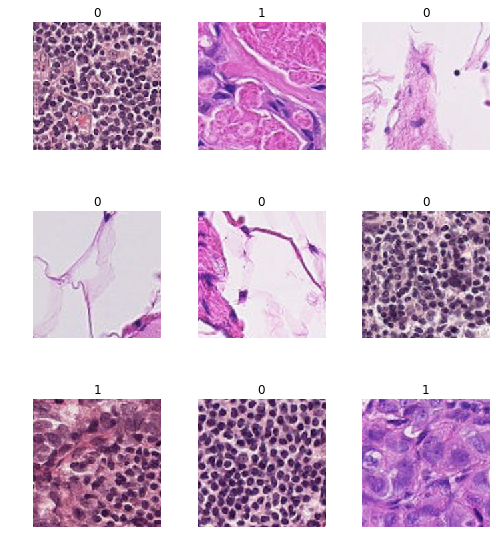

In [15]:
data.show_batch(rows=3, figsize=(7,8))

## Train model

In [18]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
#learn = create_cnn(data, models.resnet34, metrics=error_rate).to_fp16()
#learn = create_unet(data, models.resnet34, metrics=error_rate)
#learn = create_unet(data, models.resnet34, metrics=error_rate).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


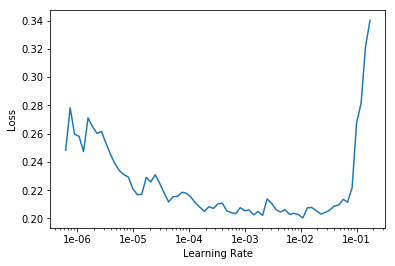

In [23]:
lr_find(learn)
learn.recorder.plot()
#learn.recorder.plot_losses()

In [24]:
lr=1e-2

In [19]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.261750,0.213555,0.080491
2,0.215039,0.164386,0.055266
3,0.176182,0.145543,0.050062
4,0.221889,0.143747,0.049858


Save weights

In [25]:
learn.save('histo-resnet34-sz192-stage-1')

In [26]:
learn.load('histo-resnet34-sz192-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: data/histo/train
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: data/histo/train;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: data/histo/train
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: data/histo/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1)

Unfreeze layers for fine tuning

In [27]:
learn.unfreeze()

Inspect learning rate plot

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


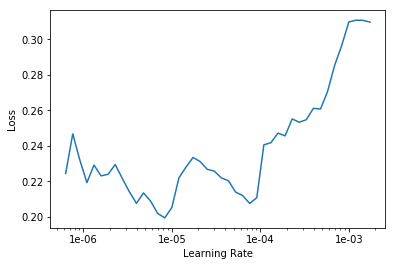

In [28]:
learn.lr_find()
learn.recorder.plot()

Pick the best learning rate from inspecting the plot

In [30]:
lrs = slice(1e-5,lr/5)

In [31]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.197657,0.150942,0.051721
2,0.190311,0.136989,0.046222
3,0.185618,0.125259,0.042359
4,0.167280,0.123099,0.040450
5,0.139360,0.143579,0.035337
6,0.116577,0.088347,0.028951
7,0.111443,0.089009,0.027860
8,0.082007,0.077608,0.024838
9,0.077655,0.076351,0.024043
10,0.082422,0.072606,0.023520


In [32]:
learn.save('histo-resnet34-sz192-stage-2')

In [33]:
learn.load('histo-resnet34-sz192-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: data/histo/train
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: data/histo/train;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: data/histo/train
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: data/histo/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1)

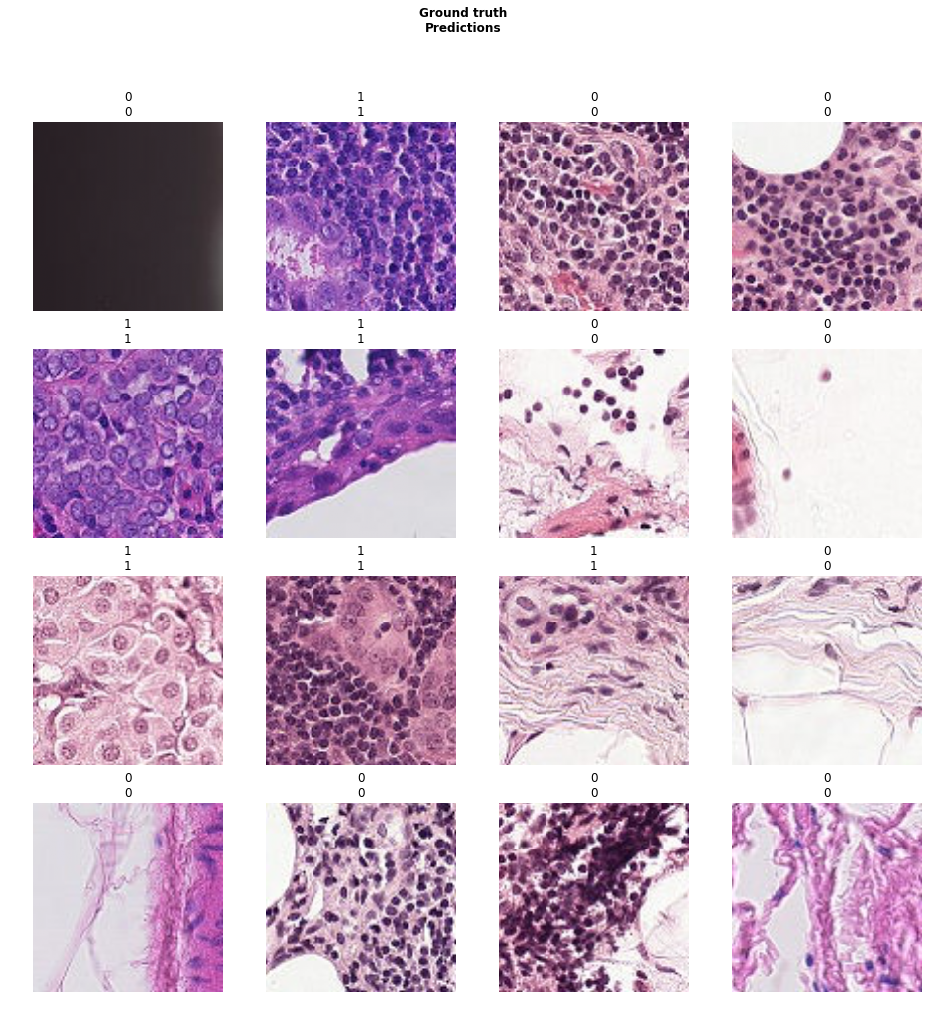

In [34]:
learn.show_results()

## Interpretation

Analyse model performance

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

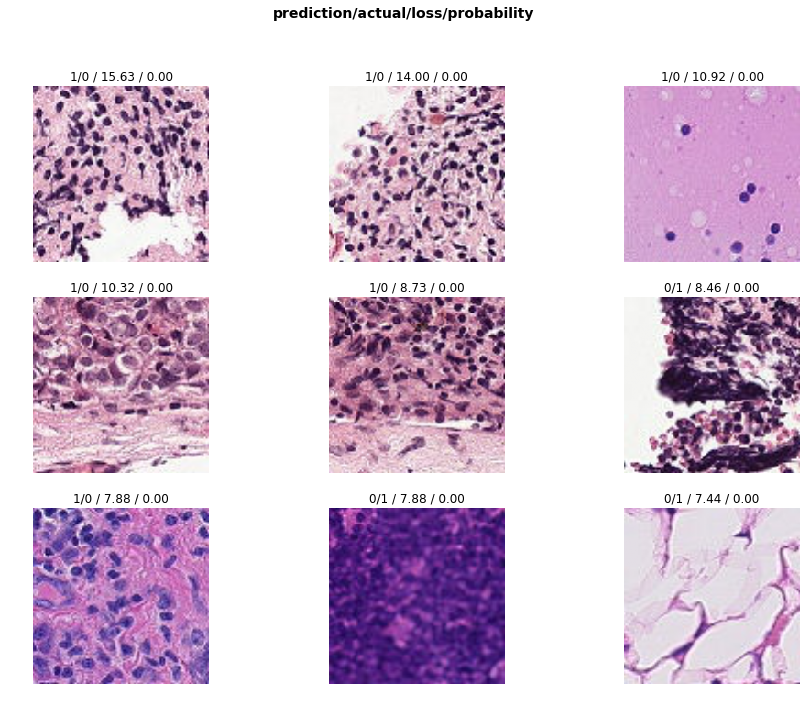

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

In [37]:
doc(interp.plot_top_losses)

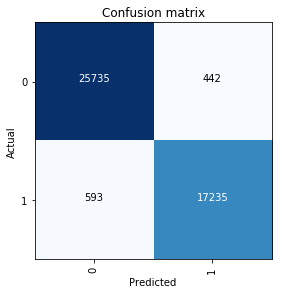

In [38]:
interp.plot_confusion_matrix()

In [39]:
interp.most_confused(min_val=2)

[(1, 0, 593), (0, 1, 442)]

## Create Kaggle submission file

Load test set file names into a dataframe

In [87]:
test_path/file

PosixPath('data/histo/test/155b2b44dbd3aaedccbd2a0057997388b4159e5e.tif')

In [89]:
test_files = []
predictions = []
count = 0
for file in sorted(os.listdir(test_path)):
    img = open_image(test_path/file)
    pred_class,pred_idx,outputs = learn.predict(img)
    test_files.append((file, pred_class))
    count = count + 1
    if count%1000 == 0:
        print ('Appended another 1000 filenames...\n')

predictions = pd.DataFrame(test_files, columns=['id', 'label'])

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filenames...

Appended another 1000 filena

Check data frame

In [92]:
predictions.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b.tif,1
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,0
4,000270442cc15af719583a8172c87cd2bd9c7746.tif,0


Remove .tif suffix from id fields in dataframe

In [98]:
suffix = '.tif'
predictions['id'] = predictions['id'].apply(lambda x: x[:-len(suffix)])
predictions.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


Save result data frame as csv

In [99]:
#TODO - modify to create correct format
predictions.to_csv('submission.csv', index=False)

Get predictions, indexes and losses from model

In [40]:
preds,y,losses = learn.get_preds(with_loss=True)

In [53]:
len(df)

220025

## Transferred Learning Option

Used optionally if the original model used a lower image resolution and you want to train a new model using higher res, but don't want to start from scratch. This will be faster.

In [ ]:
# change size and transfer size=128 trained model (faster learning)
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

## Production

Export the weights

In [58]:
learn.export()

Force the notebook to use the CPU rather than the GPU for single image classification

In [ ]:
defaults.device = torch.device('cpu')

Set the path of the image you want classified

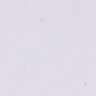

In [55]:
img = open_image(test_path/'0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif')
img

Load the model

In [60]:
learn = load_learner(train_path)

Classify the image

In [61]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 0

## Web API Source Code Example

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things to try for MK2

Masking images in a new data set and training to see if better results achieved

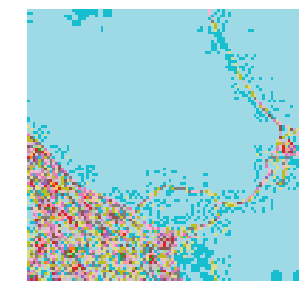

In [12]:
mask = open_mask(img_file)
mask.show(figsize=(5,5), alpha=1)

Create unet instead of cnn

In [ ]:
learn = Learner.create_unet(data, models.resnet50, metrics=error_rate)